In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

def compute_mask(im_shape):
    """Create GRBG Bayer pattern mask."""
    
    # Green pattern (occurs at (0,0) and (1,1))
    g_mask = np.zeros(im_shape)
    g_mask[0::2, 0::2] = 1  # Top-left Green
    g_mask[1::2, 1::2] = 1  # Bottom-right Green
    
    # Red pattern (occurs at (0,1))
    r_mask = np.zeros(im_shape)
    r_mask[0::2, 1::2] = 1
    
    # Blue pattern (occurs at (1,0))
    b_mask = np.zeros(im_shape)
    b_mask[1::2, 0::2] = 1
    
    mask = np.zeros(im_shape + (3,))
    mask[:, :, 0] = r_mask
    mask[:, :, 1] = g_mask
    mask[:, :, 2] = b_mask
    
    return mask


def process_image(image_path):
    """Process single image to create Bayer pattern."""
    # Read RGB image
    image_gt = cv2.imread(str(image_path))
    b, g, r = cv2.split(image_gt)
    image_gt = cv2.merge([r, g, b])  # BGR to RGB
    
    # Compute mask
    mask = compute_mask(image_gt.shape[:2])
    mask = mask.astype(np.int32)
    
    # Apply mask to create mosaic
    image_mosaic = np.zeros(image_gt.shape).astype(np.int32)
    image_mosaic[:, :, 0] = mask[..., 0] * image_gt[..., 0]
    image_mosaic[:, :, 1] = mask[..., 1] * image_gt[..., 1]
    image_mosaic[:, :, 2] = mask[..., 2] * image_gt[..., 2]
    
    # Sum channels to get Bayer pattern
    image_input = np.sum(image_mosaic, axis=2, dtype='uint16')
    
    return image_gt, mask, image_mosaic, image_input

# Set the path to your MSR dataset groundtruth image
dataset_path = 'dataset/MSR-Demosaicing/MSR-Demosaicing/Dataset_LINEAR_without_noise/bayer_panasonic'
groundtruth_dir = os.path.join(dataset_path, 'groundtruth')

# Get the first image from the groundtruth directory
image_files = os.listdir(groundtruth_dir)
image_path = os.path.join(groundtruth_dir, image_files[10])

# Process the image
image_gt, mask, image_mosaic, image_input = process_image(image_path)



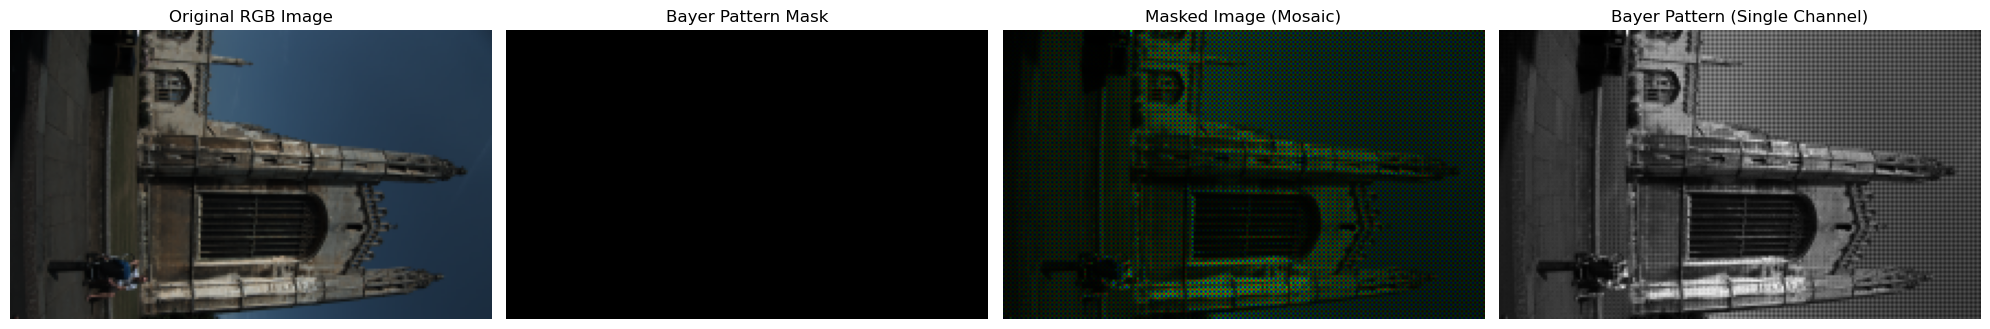

In [2]:
# Visualize results
plt.figure(figsize=(20, 5))

# Original RGB image
plt.subplot(141)
plt.imshow(image_gt)
plt.title('Original RGB Image')
plt.axis('off')

# Bayer pattern mask
plt.subplot(142)
plt.imshow(mask)
plt.title('Bayer Pattern Mask')
plt.axis('off')

# Masked image (mosaic)
plt.subplot(143)
plt.imshow(image_mosaic / 255.0)  # Normalize for display
plt.title('Masked Image (Mosaic)')
plt.axis('off')

# Final Bayer pattern (single channel)
plt.subplot(144)
plt.imshow(image_input, cmap='gray')
plt.title('Bayer Pattern (Single Channel)')
plt.axis('off')

plt.tight_layout()
plt.show()



In [5]:
image_gt.shape

(132, 220, 3)